## Machine Learning Model Training

**Dataset path:** `../data/raw/StressLevelDataset.csv`

In [1]:
#================================================================
# Add all the libraries imports needed in the project here
#================================================================
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.feature_selection import VarianceThreshold
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

# Use imblearn Pipeline for pipelines WITH a sampler step
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from pathlib import Path
import sys
# Point to the project root (adjust parents[1] to parents[2] if your notebook is deeper)
PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

#================================================================
# Imports custom preprocessing functions from 'functions.py'
#================================================================

from lib.functions import (is_binary_like,
                        _pretty_p,
                        evaluate_classifier,
                        run_models_with_importances
                        )

#================================================================
#  Initialize config
#================================================================
config = None
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")


**1) Load data & quick checks**

In [2]:
df = pd.read_csv(config['input_data']['file1'])
display(df.head())
display(df.shape)
display(df.dtypes)
display(df.isna().sum())


,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,...,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,...,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,...,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,...,2,2,4,1,4,1,4,4,5,2
4,16,28,0,7,2,3,5,1,3,2,...,3,4,3,1,2,1,5,0,5,1


(1100, 21)

anxiety_level                   int64
self_esteem                     int64
mental_health_history           int64
depression                      int64
headache                        int64
blood_pressure                  int64
sleep_quality                   int64
breathing_problem               int64
noise_level                     int64
living_conditions               int64
safety                          int64
basic_needs                     int64
academic_performance            int64
study_load                      int64
teacher_student_relationship    int64
future_career_concerns          int64
social_support                  int64
peer_pressure                   int64
extracurricular_activities      int64
bullying                        int64
stress_level                    int64
dtype: object

anxiety_level                   0
self_esteem                     0
mental_health_history           0
depression                      0
headache                        0
blood_pressure                  0
sleep_quality                   0
breathing_problem               0
noise_level                     0
living_conditions               0
safety                          0
basic_needs                     0
academic_performance            0
study_load                      0
teacher_student_relationship    0
future_career_concerns          0
social_support                  0
peer_pressure                   0
extracurricular_activities      0
bullying                        0
stress_level                    0
dtype: int64

**2) Detect numeric, binary-like, and categorical columns**

In [3]:
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
binary_like = [c for c in num_cols_all if is_binary_like(df[c])]
num_cols = [c for c in num_cols_all if c not in binary_like]
print('Numeric (non-binary-like):', num_cols)
print('Binary-like:', binary_like)
print('Categorical:', cat_cols)

Numeric (non-binary-like): ['anxiety_level', 'self_esteem', 'depression', 'headache', 'blood_pressure', 'sleep_quality', 'breathing_problem', 'noise_level', 'living_conditions', 'safety', 'basic_needs', 'academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns', 'social_support', 'peer_pressure', 'extracurricular_activities', 'bullying', 'stress_level']
Binary-like: ['mental_health_history']
Categorical: []


**3) Train/Test split & preprocessing**

In [4]:
target = 'stress_level'
X = df.drop(columns=[target])
y = df[target]

num_cols_all = X.select_dtypes(include=[np.number]).columns.tolist()
binary_like = [c for c in num_cols_all if is_binary_like(df[c])]
num_cols = [c for c in num_cols_all if c not in binary_like]
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape

((880, 20), (220, 20))

# KNN (Supervised ML)

**4) Fit KNN and evaluate**

In [5]:
knn = KNeighborsClassifier(n_neighbors=5)
pipe = Pipeline([('prep', preprocess), ('model', knn)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
evaluate_classifier(y_test, y_pred, title='KNN (k=5)')      # **Evaluation helpers**: imported fucntion from functions.py 

for k in [3,5,7,9,11]:
    m = Pipeline([('prep', preprocess), ('model', KNeighborsClassifier(n_neighbors=k, weights='distance'))])
    m.fit(X_train, y_train)
    yp = m.predict(X_test)
    print(f'k={k}: Acc={round(accuracy_score(y_test, yp),4)}')
    
print('')

for k in [3,5,7,9,11]:
    m = Pipeline([('prep', preprocess), ('model', KNeighborsClassifier(n_neighbors=k, weights='distance'))])
    cv = cross_val_score(m, X_train, y_train, cv=5, scoring='accuracy').mean()
    print(f'k={k}: CV accuracy={cv:.4f}')


=== KNN (k=5) ===
Accuracy: 0.8545

Confusion matrix:
[[60 10  4]
 [ 2 66  4]
 [ 7  5 62]]

Classification report:
              precision    recall  f1-score   support

           0     0.8696    0.8108    0.8392        74
           1     0.8148    0.9167    0.8627        72
           2     0.8857    0.8378    0.8611        74

    accuracy                         0.8545       220
   macro avg     0.8567    0.8551    0.8543       220
weighted avg     0.8571    0.8545    0.8543       220

k=3: Acc=0.8545
k=5: Acc=0.8545
k=7: Acc=0.8409
k=9: Acc=0.85
k=11: Acc=0.85

k=3: CV accuracy=0.8750
k=5: CV accuracy=0.8739
k=7: CV accuracy=0.8784
k=9: CV accuracy=0.8693
k=11: CV accuracy=0.8693


**5) Simple pre-selection (VarianceThreshold) & Save pipeline**

In [6]:
vt = VarianceThreshold(threshold=0.0)
vt_pipe = Pipeline([('prep', preprocess), ('vt', vt)])
Xt = vt_pipe.fit_transform(X_train)
print('Transformed shape:', Xt.shape)

clf = Pipeline([('prep', preprocess), ('model', KNeighborsClassifier(n_neighbors=5, weights='distance'))])
clf.fit(X_train, y_train)
with open('stress_pipeline.pkl','wb') as f:
    pickle.dump(clf, f)
print('Saved stress_pipeline.pkl')

Transformed shape: (880, 20)
Saved stress_pipeline.pkl


# Supervised ML (Core Models and Metrics)

**6) Train Logistic Regression, KNN, Decision Tree**

=== KNN(k=5) ===
Accuracy: 0.8545

Confusion matrix:
[[59  9  6]
 [ 2 66  4]
 [ 6  5 63]]

Classification report:
              precision    recall  f1-score   support

           0     0.8806    0.7973    0.8369        74
           1     0.8250    0.9167    0.8684        72
           2     0.8630    0.8514    0.8571        74

    accuracy                         0.8545       220
   macro avg     0.8562    0.8551    0.8541       220
weighted avg     0.8565    0.8545    0.8540       220

KNN(k=5): no native feature_importances_ or coef_ (skipping top-features).

=== LogisticRegression ===
Accuracy: 0.8818

Confusion matrix:
[[63  5  6]
 [ 3 66  3]
 [ 7  2 65]]

Classification report:
              precision    recall  f1-score   support

           0     0.8630    0.8514    0.8571        74
           1     0.9041    0.9167    0.9103        72
           2     0.8784    0.8784    0.8784        74

    accuracy                         0.8818       220
   macro avg     0.8818    0.8821

,feature,coef_0,coef_1,coef_2,abs_mean_coef
4,num__blood_pressure,1.455814,-2.800922,1.345108,1.867281
15,num__social_support,1.064782,-1.343949,0.279167,0.895966
19,remainder__mental_health_history,0.395030,-0.574510,0.179481,0.383007
1,num__self_esteem,0.190348,0.255073,-0.445421,0.296947
11,num__academic_performance,0.387103,-0.044463,-0.342640,0.258069
12,num__study_load,-0.368665,0.258219,0.110446,0.245777
13,num__teacher_student_relationship,0.205090,-0.362360,0.157270,0.241573
10,num__basic_needs,0.347154,-0.229818,-0.117336,0.231436
3,num__headache,-0.228626,-0.081550,0.310176,0.206784
5,num__sleep_quality,0.150039,0.068295,-0.218333,0.145556


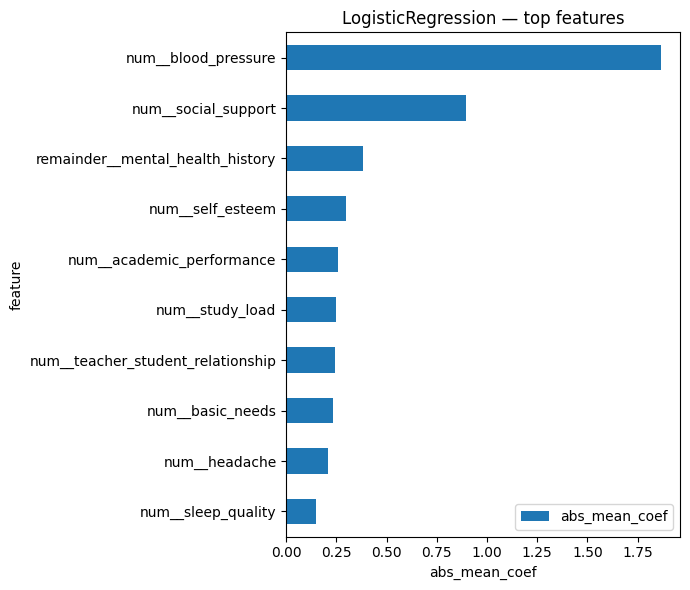

=== DecisionTree ===
Accuracy: 0.8591

Confusion matrix:
[[61  7  6]
 [ 6 64  2]
 [ 4  6 64]]

Classification report:
              precision    recall  f1-score   support

           0     0.8592    0.8243    0.8414        74
           1     0.8312    0.8889    0.8591        72
           2     0.8889    0.8649    0.8767        74

    accuracy                         0.8591       220
   macro avg     0.8597    0.8594    0.8591       220
weighted avg     0.8600    0.8591    0.8591       220


Top 10 features for DecisionTree:


,feature,importance
4,num__blood_pressure,0.375749
11,num__academic_performance,0.343133
5,num__sleep_quality,0.044360
13,num__teacher_student_relationship,0.043331
8,num__living_conditions,0.031277
9,num__safety,0.026165
10,num__basic_needs,0.023637
2,num__depression,0.019776
15,num__social_support,0.014540
1,num__self_esteem,0.013738


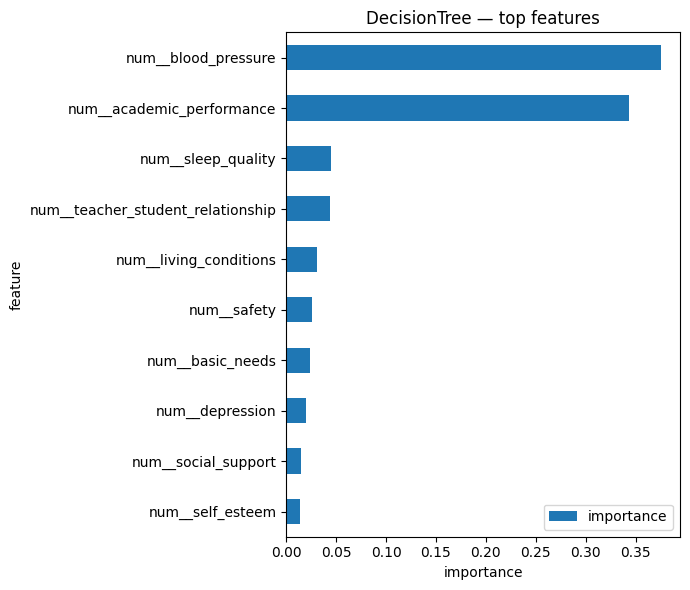

In [7]:
models = {
    'KNN(k=5)': KNeighborsClassifier(n_neighbors=5, weights='distance'),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

results = run_models_with_importances(
    models=models,
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10,
    plot=True,
    save_csv=False
)

# Ensembles (Random Forest, Gradient Boosting and AdaBoost)

**7) Fit and evaluate ensembles**

=== Random Forest ===
Accuracy: 0.8818

Confusion matrix:
[[63  5  6]
 [ 4 65  3]
 [ 5  3 66]]

Classification report:
              precision    recall  f1-score   support

           0     0.8750    0.8514    0.8630        74
           1     0.8904    0.9028    0.8966        72
           2     0.8800    0.8919    0.8859        74

    accuracy                         0.8818       220
   macro avg     0.8818    0.8820    0.8818       220
weighted avg     0.8817    0.8818    0.8817       220


Top 10 features for Random Forest:


,feature,importance
4,num__blood_pressure,0.121358
13,num__teacher_student_relationship,0.078934
11,num__academic_performance,0.074508
5,num__sleep_quality,0.073114
2,num__depression,0.071477
15,num__social_support,0.065580
18,num__bullying,0.057219
0,num__anxiety_level,0.055405
14,num__future_career_concerns,0.052372
17,num__extracurricular_activities,0.051341


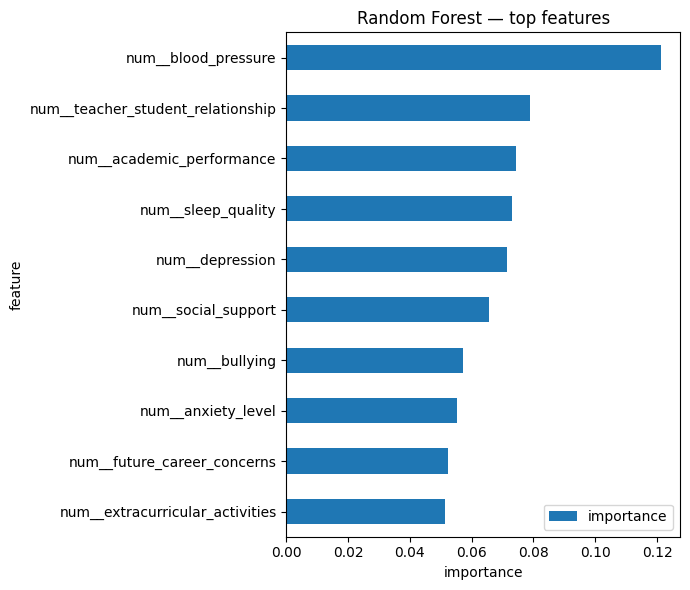

=== Gradient Boosting ===
Accuracy: 0.8773

Confusion matrix:
[[61  7  6]
 [ 1 67  4]
 [ 6  3 65]]

Classification report:
              precision    recall  f1-score   support

           0     0.8971    0.8243    0.8592        74
           1     0.8701    0.9306    0.8993        72
           2     0.8667    0.8784    0.8725        74

    accuracy                         0.8773       220
   macro avg     0.8780    0.8778    0.8770       220
weighted avg     0.8780    0.8773    0.8768       220


Top 10 features for Gradient Boosting:


,feature,importance
4,num__blood_pressure,0.262686
5,num__sleep_quality,0.236636
11,num__academic_performance,0.152462
13,num__teacher_student_relationship,0.115943
10,num__basic_needs,0.031455
15,num__social_support,0.026965
1,num__self_esteem,0.026631
3,num__headache,0.018744
0,num__anxiety_level,0.018189
17,num__extracurricular_activities,0.017924


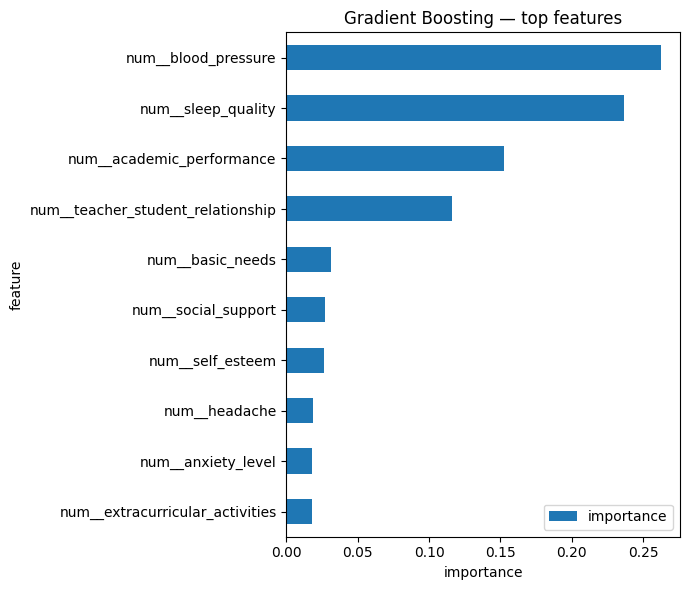

=== AdaBoost ===
Accuracy: 0.8864

Confusion matrix:
[[59  6  9]
 [ 1 67  4]
 [ 4  1 69]]

Classification report:
              precision    recall  f1-score   support

           0     0.9219    0.7973    0.8551        74
           1     0.9054    0.9306    0.9178        72
           2     0.8415    0.9324    0.8846        74

    accuracy                         0.8864       220
   macro avg     0.8896    0.8868    0.8858       220
weighted avg     0.8894    0.8864    0.8855       220


Top 10 features for AdaBoost:


,feature,importance
4,num__blood_pressure,0.304251
1,num__self_esteem,0.224047
15,num__social_support,0.125452
13,num__teacher_student_relationship,0.044484
11,num__academic_performance,0.038126
12,num__study_load,0.035036
5,num__sleep_quality,0.033194
3,num__headache,0.026049
2,num__depression,0.023973
17,num__extracurricular_activities,0.020929


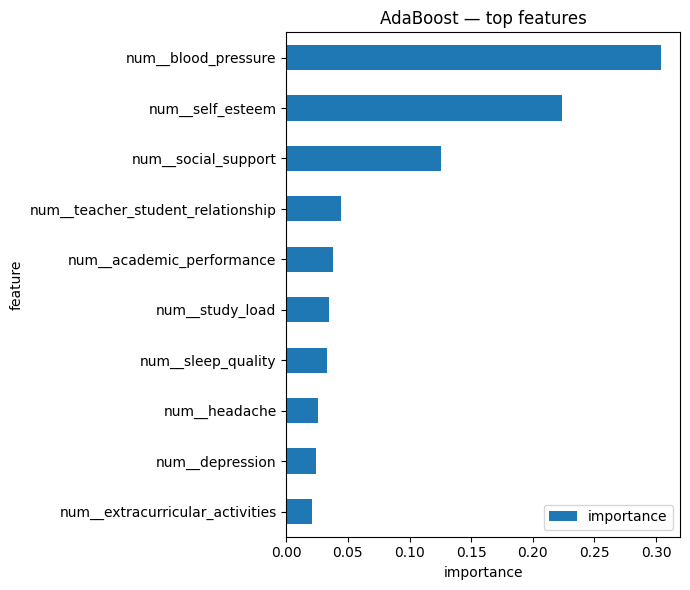

In [8]:
# rf = Pipeline([('prep', preprocess), ('model', RandomForestClassifier(n_estimators=200, random_state=42))])
# gb = Pipeline([('prep', preprocess), ('model', GradientBoostingClassifier(random_state=42))])
# ada = Pipeline([('prep', preprocess), ('model', AdaBoostClassifier(n_estimators=200, learning_rate=0.5, random_state=42))])

# for name, pipe in [('RandomForest', rf), ('GradientBoosting', gb), ('AdaBoost', ada)]:
#     pipe.fit(X_train, y_train)
#     y_pred = pipe.predict(X_test)
#     evaluate_classifier(y_test, y_pred, title=name)   # accuracy + confusion + per-class precision/recall/F1

# 1) Baseline (no resampling) -> sklearn Pipeline
results_base = run_models_with_importances(
    models={'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10, 
    plot=True
)
# 1) Baseline (no resampling) -> sklearn Pipeline
results_base = run_models_with_importances(
    models={'Gradient Boosting': GradientBoostingClassifier(random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10, 
    plot=True
)
# 1) Baseline (no resampling) -> sklearn Pipeline
results_base = run_models_with_importances(
    models={'AdaBoost': AdaBoostClassifier(n_estimators=200, learning_rate=0.5, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10, 
    plot=True
)

# Hyperparameter Tuning

**8) Tuning GradientBoosting and AdaBoost (GridSearchCV)**

In [9]:

base = Pipeline([('prep', preprocess), ('model', GradientBoostingClassifier(random_state=42))])
param_grid = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__learning_rate': [0.05, 0.1, 0.5, 1.0],
    'model__max_depth': [2, 3]
}
gs = GridSearchCV(base, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs.fit(X_train, y_train)
print('Best params (Grid):', gs.best_params_)
best_gs = gs.best_estimator_

best_gs.fit(X_train, y_train)
pred = best_gs.predict(X_test)
print('Test accuracy (best tuned GB):', round(accuracy_score(y_test, pred),4))

print('')

base_ada = Pipeline([('prep', preprocess), ('model', AdaBoostClassifier(random_state=42))])
param_grid_ada = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__learning_rate': [0.05, 0.1, 0.5, 1.0]
    # 'model__max_depth': [2, 3]
}
gs_ada = GridSearchCV(base_ada, param_grid_ada, cv=5, scoring='accuracy', n_jobs=-1)
gs_ada.fit(X_train, y_train)
print("AdaBoost best params:", gs_ada.best_params_)
best_ada = gs_ada.best_estimator_

best_ada.fit(X_train, y_train)
pred = best_ada.predict(X_test)
print('Test accuracy (best tuned ADA):', round(accuracy_score(y_test, pred),4))

print('')

for name, pipe in [('GradientBoosting', base), ('AdaBoost', base_ada)]:
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    evaluate_classifier(y_test, y_pred, title=name) 


Best params (Grid): {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 300}
Test accuracy (best tuned GB): 0.8636

AdaBoost best params: {'model__learning_rate': 0.05, 'model__n_estimators': 300}
Test accuracy (best tuned ADA): 0.8864

=== GradientBoosting ===
Accuracy: 0.8773

Confusion matrix:
[[61  7  6]
 [ 1 67  4]
 [ 6  3 65]]

Classification report:
              precision    recall  f1-score   support

           0     0.8971    0.8243    0.8592        74
           1     0.8701    0.9306    0.8993        72
           2     0.8667    0.8784    0.8725        74

    accuracy                         0.8773       220
   macro avg     0.8780    0.8778    0.8770       220
weighted avg     0.8780    0.8773    0.8768       220

=== AdaBoost ===
Accuracy: 0.8864

Confusion matrix:
[[60  7  7]
 [ 2 66  4]
 [ 3  2 69]]

Classification report:
              precision    recall  f1-score   support

           0     0.9231    0.8108    0.8633        74
           1

# Imbalanced Data (Multi-class)

**9) Class distribution**

In [10]:
print(y_train.value_counts(normalize=True).round(3))
print(y_test.value_counts(normalize=True).round(3))

stress_level
0    0.340
2    0.335
1    0.325
Name: proportion, dtype: float64
stress_level
0    0.336
2    0.336
1    0.327
Name: proportion, dtype: float64


**10) Baseline Logistic Regression and resampling variants**

=== Baseline LogReg ===
Accuracy: 0.8818

Confusion matrix:
[[63  5  6]
 [ 3 66  3]
 [ 7  2 65]]

Classification report:
              precision    recall  f1-score   support

           0     0.8630    0.8514    0.8571        74
           1     0.9041    0.9167    0.9103        72
           2     0.8784    0.8784    0.8784        74

    accuracy                         0.8818       220
   macro avg     0.8818    0.8821    0.8820       220
weighted avg     0.8816    0.8818    0.8817       220


Top 10 features for Baseline LogReg:


,feature,coef_0,coef_1,coef_2,abs_mean_coef
4,num__blood_pressure,1.455814,-2.800922,1.345108,1.867281
15,num__social_support,1.064782,-1.343949,0.279167,0.895966
19,remainder__mental_health_history,0.395030,-0.574510,0.179481,0.383007
1,num__self_esteem,0.190348,0.255073,-0.445421,0.296947
11,num__academic_performance,0.387103,-0.044463,-0.342640,0.258069
12,num__study_load,-0.368665,0.258219,0.110446,0.245777
13,num__teacher_student_relationship,0.205090,-0.362360,0.157270,0.241573
10,num__basic_needs,0.347154,-0.229818,-0.117336,0.231436
3,num__headache,-0.228626,-0.081550,0.310176,0.206784
5,num__sleep_quality,0.150039,0.068295,-0.218333,0.145556


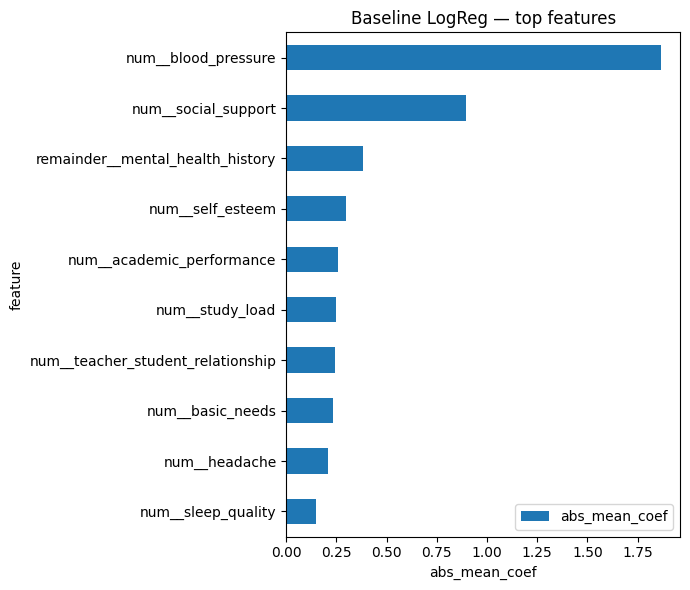

=== LogReg + ROS ===
Accuracy: 0.8818

Confusion matrix:
[[63  5  6]
 [ 3 66  3]
 [ 7  2 65]]

Classification report:
              precision    recall  f1-score   support

           0     0.8630    0.8514    0.8571        74
           1     0.9041    0.9167    0.9103        72
           2     0.8784    0.8784    0.8784        74

    accuracy                         0.8818       220
   macro avg     0.8818    0.8821    0.8820       220
weighted avg     0.8816    0.8818    0.8817       220


Top 10 features for LogReg + ROS:


,feature,coef_0,coef_1,coef_2,abs_mean_coef
4,num__blood_pressure,1.492984,-2.832381,1.339397,1.888254
15,num__social_support,1.090945,-1.359288,0.268343,0.906192
19,remainder__mental_health_history,0.399227,-0.612633,0.213407,0.408422
1,num__self_esteem,0.189814,0.264399,-0.454213,0.302808
11,num__academic_performance,0.390438,-0.050341,-0.340097,0.260292
12,num__study_load,-0.370063,0.259983,0.110080,0.246709
10,num__basic_needs,0.353926,-0.248466,-0.105460,0.235951
13,num__teacher_student_relationship,0.206939,-0.345931,0.138993,0.230621
3,num__headache,-0.240390,-0.072954,0.313344,0.208896
5,num__sleep_quality,0.154885,0.077588,-0.232473,0.154982


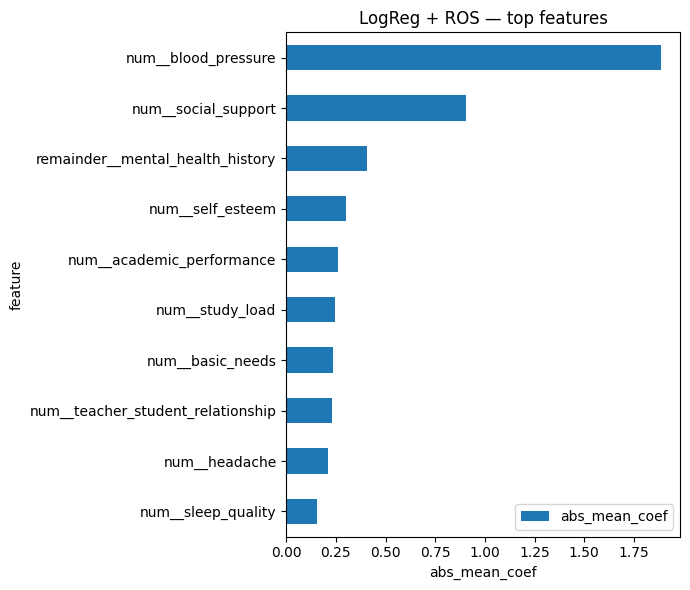

=== LogReg + RUS ===
Accuracy: 0.8818

Confusion matrix:
[[63  5  6]
 [ 3 66  3]
 [ 7  2 65]]

Classification report:
              precision    recall  f1-score   support

           0     0.8630    0.8514    0.8571        74
           1     0.9041    0.9167    0.9103        72
           2     0.8784    0.8784    0.8784        74

    accuracy                         0.8818       220
   macro avg     0.8818    0.8821    0.8820       220
weighted avg     0.8816    0.8818    0.8817       220


Top 10 features for LogReg + RUS:


,feature,coef_0,coef_1,coef_2,abs_mean_coef
4,num__blood_pressure,1.417056,-2.770372,1.353316,1.846914
15,num__social_support,1.053131,-1.327495,0.274364,0.884997
19,remainder__mental_health_history,0.337419,-0.555406,0.217987,0.370271
11,num__academic_performance,0.408408,-0.058528,-0.349880,0.272272
1,num__self_esteem,0.157335,0.250667,-0.408001,0.272001
12,num__study_load,-0.381920,0.262441,0.119479,0.254613
13,num__teacher_student_relationship,0.170324,-0.355681,0.185358,0.237121
10,num__basic_needs,0.346518,-0.227325,-0.119194,0.231012
3,num__headache,-0.200866,-0.094348,0.295214,0.196809
5,num__sleep_quality,0.195679,0.056895,-0.252574,0.168382


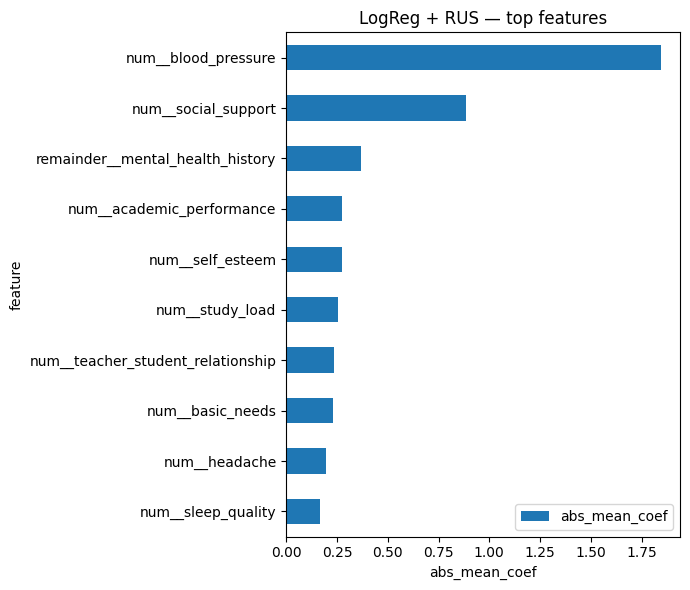

=== LogReg + SMOTE ===
Accuracy: 0.8864

Confusion matrix:
[[63  5  6]
 [ 2 67  3]
 [ 6  3 65]]

Classification report:
              precision    recall  f1-score   support

           0     0.8873    0.8514    0.8690        74
           1     0.8933    0.9306    0.9116        72
           2     0.8784    0.8784    0.8784        74

    accuracy                         0.8864       220
   macro avg     0.8863    0.8868    0.8863       220
weighted avg     0.8863    0.8864    0.8861       220


Top 10 features for LogReg + SMOTE:


,feature,coef_0,coef_1,coef_2,abs_mean_coef
4,num__blood_pressure,1.458550,-2.855111,1.396561,1.903407
15,num__social_support,1.092453,-1.372384,0.279931,0.914923
19,remainder__mental_health_history,0.350769,-0.628790,0.278021,0.419193
1,num__self_esteem,0.199681,0.241123,-0.440804,0.293869
13,num__teacher_student_relationship,0.190963,-0.371825,0.180862,0.247883
11,num__academic_performance,0.367528,-0.040082,-0.327447,0.245019
12,num__study_load,-0.348251,0.259887,0.088363,0.232167
10,num__basic_needs,0.323298,-0.243756,-0.079542,0.215532
3,num__headache,-0.211914,-0.096598,0.308512,0.205674
18,num__bullying,-0.084911,-0.146218,0.231129,0.154086


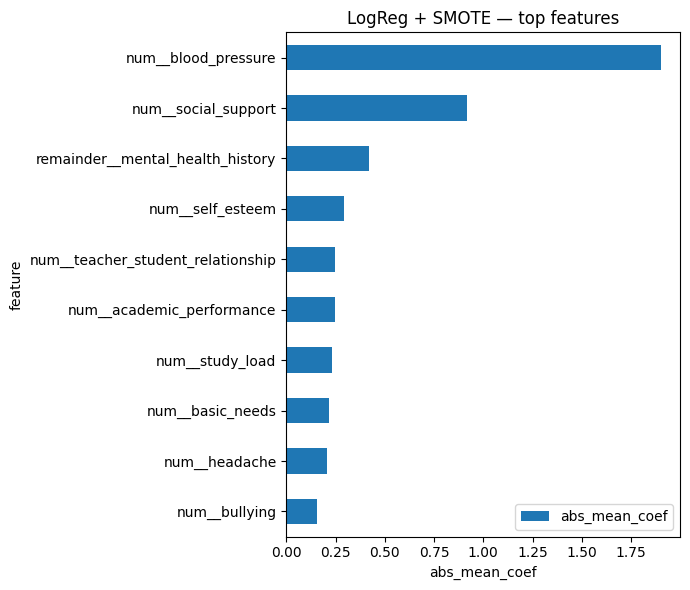

In [ ]:
# def eval_simple(pipe, title):
#     pipe.fit(X_train, y_train)
#     yp = pipe.predict(X_test)
#     evaluate_classifier(y_test, yp, title)

# base = Pipeline([('prep', preprocess), 
#                  ('model', LogisticRegression(max_iter=1000, random_state=42))])
# ros  = ImbPipeline([('prep', preprocess), 
#                     ('ros', RandomOverSampler(random_state=42)), ('model', LogisticRegression(max_iter=1000, random_state=42))])
# rus  = ImbPipeline([('prep', preprocess), 
#                     ('rus', RandomUnderSampler(random_state=42)), ('model', LogisticRegression(max_iter=1000, random_state=42))])
# smt  = ImbPipeline([('prep', preprocess), 
#                     ('smt', SMOTE(random_state=42)), ('model', LogisticRegression(max_iter=1000, random_state=42))])

# for title, pipe in [('Baseline LogReg', base), ('LogReg + ROS', ros), ('LogReg + RUS', rus), ('LogReg + SMOTE', smt)]:
#     eval_simple(pipe, title)

# 1) Baseline (no resampling) -> sklearn Pipeline
results_base = run_models_with_importances(
    models={'Baseline LogReg': LogisticRegression(max_iter=1000, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    top=10, 
    plot=True
)
# 2) Oversample (ROS) -> imblearn Pipeline + RandomOverSampler
results_ros = run_models_with_importances(
    models={'LogReg + ROS': LogisticRegression(max_iter=1000, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    pipeline_cls=ImbPipeline,                      # use imblearn Pipeline
    sampler=RandomOverSampler(random_state=42),    # insert sampler step
    top=10, 
    plot=True
)
# 3) Undersample (RUS)
results_rus = run_models_with_importances(
    models={'LogReg + RUS': LogisticRegression(max_iter=1000, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    pipeline_cls=ImbPipeline,
    sampler=RandomUnderSampler(random_state=42),
    top=10, 
    plot=True
)
# 4) SMOTE
results_smt = run_models_with_importances(
    models={'LogReg + SMOTE': LogisticRegression(max_iter=1000, random_state=42)},
    preprocess=preprocess,
    X_train=X_train, y_train=y_train,
    X_test=X_test,   y_test=y_test,
    pipeline_cls=ImbPipeline,
    sampler=SMOTE(random_state=42),
    top=10, 
    plot=True
)

## Unsupervised Learning (PCA + Clustering)

**11) PCA (numeric features only)**

In [12]:
num_all = df.select_dtypes(include=[np.number]).columns.tolist()
Xnum = df[num_all].dropna().values
Xnum_scaled = StandardScaler().fit_transform(Xnum)
pca = PCA(n_components=2)
X2 = pca.fit_transform(Xnum_scaled)
print('Explained variance (2 comps):', pca.explained_variance_ratio_.round(3), 'Sum=', round(pca.explained_variance_ratio_.sum(),3))

Explained variance (2 comps): [0.605 0.057] Sum= 0.662


**12) KMeans & Hierarchical clustering on PCA(2)**

In [13]:
km = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_km = km.fit_predict(X2)
agg = AgglomerativeClustering(n_clusters=3)
labels_ag = agg.fit_predict(X2)
print('Silhouette (KMeans):', round(silhouette_score(X2, labels_km), 3))
print('Silhouette (Agglomerative):', round(silhouette_score(X2, labels_ag), 3))

Silhouette (KMeans): 0.731
Silhouette (Agglomerative): 0.73


**13) 2D scatter (optional)**

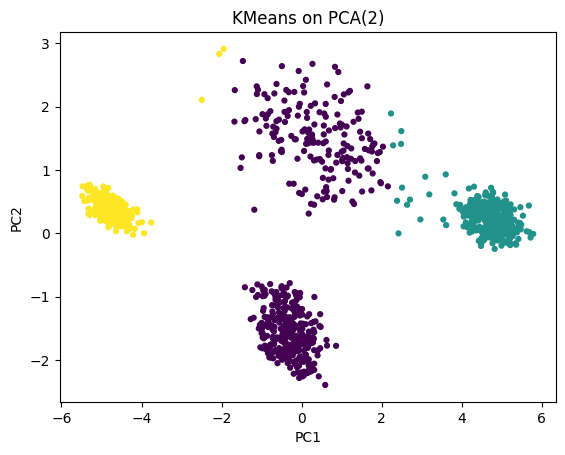

In [14]:
plt.scatter(X2[:,0], X2[:,1], c=labels_km, s=12)
plt.title('KMeans on PCA(2)')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()